In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/Work/Sciencing/Data

/content/drive/MyDrive/Work/Sciencing/Data


In [3]:
!python -V

Python 3.7.15


In [ ]:
!pip install --user scipy==1.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.9 MB 1.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.5.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Install dependencies (nilearn and PLS tools)

In [4]:
!pip install nilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!git clone https://github.com/rmarkello/pyls.git

fatal: destination path 'pyls' already exists and is not an empty directory.


Importage

In [6]:
cd pyls/

/content/drive/MyDrive/Work/Sciencing/Data/pyls


In [38]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import exp,sin,cos,sqrt,pi, r_,floor,zeros
import scipy.io
from matplotlib.tri import Triangulation
from nilearn import plotting, datasets, surface  
from matplotlib import cm
from matplotlib.pyplot import subplot
import nibabel as nib
from matplotlib.colors import LinearSegmentedColormap
import os, sys
sys.path.append(os.getcwd())
from pyls.plotting.meancentered import plot_contrast
from pyls.types.meancentered import meancentered_pls


In [8]:
def plot_surface_mpl(vtx,tri,data=None,rm=None,reorient='tvb',view='superior',
                     shaded=False,ax=None,figsize=(6,4), title=None,
                     lthr=None,uthr=None, nz_thr = 1E-20,
                     shade_kwargs = {'edgecolors': 'k', 'linewidth': 0.1,
                                     'alpha': None, 'cmap': 'coolwarm',
                                     'vmin': None, 'vmax': None}):
                        
  r"""Plot surfaces, surface patterns, and region patterns with matplotlib
    
  This is a general-use function for neuroimaging surface-based data, and 
  does not necessarily require construction of or interaction with tvb 
  datatypes. 

  See also:  plot_surface_mpl_mv



  Parameters
  ----------
  
  vtx           : N vertices x 3 array of surface vertex xyz coordinates 

  tri           : N faces x 3 array of surface faces

  data          : array of numbers to colour surface with. Can be either 
                  a pattern across surface vertices (N vertices x 1 array),
                  or a pattern across the surface's region mapping 
                  (N regions x 1 array), in which case the region mapping 
                  bust also be given as an argument. 
                  
  rm            : region mapping - N vertices x 1 array with (up to) N 
                  regions unique values; each element specifies which 
                  region the corresponding surface vertex is mapped to 

  reorient      : modify the vertex coordinate frame and/or orientation 
                  so that the same default rotations can subsequently be 
                  used for image views. The standard coordinate frame is 
                  xyz; i.e. first,second,third axis = left-right, 
                  front-back, and up-down, respectively. The standard 
                  starting orientation is axial view; i.e. looking down on
                  the brain in the x-y plane.
                  
                  Options: 

                    tvb (default)   : swaps the first 2 axes and applies a rotation
                                              
                    fs              : for the standard freesurfer (RAS) orientation; 
                                      e.g. fsaverage lh.orig. 
                                      No transformations needed for this; so is 
                                      gives same result as reorient=None

  view          : specify viewing angle. 
  
                  This can be done in one of two ways: by specifying a string 
                  corresponding to a standard viewing angle, or by providing 
                  a tuple or list of tuples detailing exact rotations to apply 
                  around each axis. 
                  
                  Standard view options are:
    
                  lh_lat / lh_med / rh_lat / rh_med / 
                  superior / inferior / posterior / anterior

                  (Note: if the surface contains both hemispheres, then medial 
                   surfaces will not be visible, so e.g. 'rh_med' will look the 
                   same as 'lh_lat')
                   
                  Arbitrary rotations can be specied by a tuple or a list of 
                  tuples, each with two elements, the first defining the axis 
                  to rotate around [0,1,2], the second specifying the angle in 
                  degrees. When a list is given the rotations are applied 
                  sequentially in the order given. 
                  
                  Example: rotations = [(0,45),(1,-45)] applies 45 degrees 
                  rotation around the first axis, followed by 45 degrees rotate 
                  around the second axis. 

  lthr/uthr     : lower/upper thresholds - set to zero any datapoints below / 
                  above these values
  
  nz_thr        : near-zero threshold - set to zero all datapoints with absolute 
                  values smaller than this number. Default is a very small 
                  number (1E-20), which unless your data has very small numbers, 
                  will only mask out actual zeros. 

  shade_kwargs  : dictionary specifiying shading options

                  Most relevant options (see matplotlib 'tripcolor' for full details):
                  
                    - 'shading'        (either 'gourand' or omit; 
                                        default is 'flat')
                    - 'edgecolors'     'k' = black is probably best
                    - 'linewidth'      0.1 works well; note that the visual 
                                       effect of this will depend on both the 
                                       surface density and the figure size 
                    - 'cmap'           colormap
                    - 'vmin'/'vmax'    scale colormap to these values
                    - 'alpha'          surface opacity
                  
  ax            : figure axis
  
  figsize       : figure size (ignore if ax provided)
  
  title         : text string to place above figure
  
  
  
                  
  Usage
  -----
       

  Basic freesurfer example:

  import nibabel as nib
  vtx,tri = nib.freesurfer.read_geometry('subjects/fsaverage/surf/lh.orig')
  plot_surface_mpl(vtx,tri,view='lh_lat',reorient='fs')



  Basic tvb example:
  
  ctx = cortex.Cortex.from_file(source_file = ctx_file,
                                region_mapping_file =rm_file)
  vtx,tri,rm = ctx.vertices,ctx.triangles,ctx.region_mapping
  conn = connectivity.Connectivity.from_file(conn_file); conn.configure()
  isrh_reg = conn.is_right_hemisphere(range(conn.number_of_regions))
  isrh_vtx = np.array([isrh_reg[r] for r in rm])
  dat = conn.tract_lengths[:,5]

  plot_surface_mpl(vtx=vtx,tri=tri,rm=rm,data=dat,view='inferior',title='inferior')

  fig, ax = plt.subplots()
  plot_surface_mpl(vtx=vtx,tri=tri,rm=rm,data=dat, view=[(0,-90),(1,55)],ax=ax,
                   title='lh angle',shade_kwargs={'shading': 'gouraud', 'cmap': 'rainbow'})

   
  """
    
  # Copy things to make sure we don't modify things 
  # in the namespace inadvertently. 
    
  vtx,tri = vtx.copy(),tri.copy()
  if data is not None: data = data.copy()

  # 1. Set the viewing angle 
  
  if reorient == 'tvb':
    # The tvb default brain has coordinates in the order 
    # yxz for some reason. So first change that:   
    vtx = np.array([vtx[:,1],vtx[:,0],vtx[:,2]]).T.copy()
    
    # Also need to reflect in the x axis
    vtx[:,0]*=-1

  # (reorient == 'fs' is same as reorient=None; so not strictly needed
  #  but is included for clarity)
   


  # ...get rotations for standard view options
    
  if   view == 'lh_lat'    : rots =  [(0,-90),(1,90)  ]
  elif view == 'lh_med'    : rots =  [(0,-90),(1,-90) ] 
  elif view == 'rh_lat'    : rots =  [(0,-90),(1,-90) ]
  elif view == 'rh_med'    : rots =  [(0,-90),(1,90)  ]
  elif view == 'superior'  : rots =   None
  elif view == 'inferior'  : rots =   (1,180)
  elif view == 'anterior'  : rots =   (0,-90)
  elif view == 'posterior' : rots =  [(0, -90),(1,180)]
  elif (type(view) == tuple) or (type(view) == list): rots = view 

  # (rh_lat is the default 'view' argument because no rotations are 
  #  for that one; so if no view is specified when the function is called, 
  #  the 'rh_lat' option is chose here and the surface is shown 'as is' 
                            
                            
  # ...apply rotations                          
     
  if rots is None: rotmat = np.eye(3)
  else:            rotmat = get_combined_rotation_matrix(rots)
  vtx = np.dot(vtx,rotmat)

                                    
      
  # 2. Sort out the data
                                    
                                    
  # ...if no data is given, plot a vector of 1s. 
  #    if using region data, create corresponding surface vector 
  if data is None: 
    data = np.ones(vtx.shape[0]) 
  elif data.shape[0] != vtx.shape[0]: 
    data = np.array([data[r] for r in rm])
    
  # ...apply thresholds
  if uthr: data *= (data < uthr)
  if lthr: data *= (data > lthr)
  data *= (np.abs(data) > nz_thr)

                                    
  # 3. Create the surface triangulation object 
  
  x,y,z = vtx.T
  tx,ty,tz = vtx[tri].mean(axis=1).T
  tr = Triangulation(x,y,tri[np.argsort(tz)])
                
  # 4. Make the figure 

  if ax is None: fig, ax = plt.subplots(figsize=figsize)  
  
  #if shade = 'gouraud': shade_opts['shade'] = 
  tc = ax.tripcolor(tr, np.squeeze(data), **shade_kwargs)
                        
  ax.set_aspect('equal')
  ax.axis('off')
    
  if title is not None: ax.set_title(title, color='white')
  return tc
#@title function for plotting surface

In [9]:
def plot_surface_mpl_mv(vtx=None,tri=None,data=None,rm=None,hemi=None,   # Option 1
                        vtx_lh=None,tri_lh=None,data_lh=None,rm_lh=None, # Option 2
                        vtx_rh=None,tri_rh=None,data_rh=None,rm_rh=None,
                        title=None,**kwargs):

  r"""Convenience wrapper on plot_surface_mpl for multiple views 
   
  This function calls plot_surface_mpl five times to give a complete 
  picture of a surface- or region-based spatial pattern. 

  As with plot_surface_mpl, this function is written so as to be 
  generally usable with neuroimaging surface-based data, and does not 
  require construction of of interaction with tvb datatype objects. 

  In order for the medial surfaces to be displayed properly, it is 
  necessary to separate the left and right hemispheres. This can be 
  done in one of two ways: 

  1. Provide single arrays for vertices, faces, data, and 
     region mappings, and addition provide arrays of indices for 
     each of these (vtx_inds,tr_inds,rm_inds) with 0/False 
     indicating left hemisphere vertices/faces/regions, and 1/True 
     indicating right hemisphere. 

     Note: this requires that 

  2. Provide separate vertices,faces,data,and region mappings for 
     each hemisphere (vtx_lh,tri_lh; vtx_rh,tri_rh,etc...)


 
  Parameters
  ----------

  (see also plot_surface_mpl parameters info for more details)

  (Option 1)

  vtx               :  surface vertices
 
  tri               : surface faces

  data              : spatial pattern to plot

  rm                : surface vertex to region mapping

  hemi              : hemisphere labels for each vertex
                      (1/True = right, 0/False = left) - 
      

  OR

  (Option 2)

  vtx_lh            : left hemisphere surface_vertices
  vtx_rh            : right ``      ``    ``     ``
  
  tri_lh            : left hemisphere surface faces 
  tri_rh            : right ``      ``    ``     ``

  data_lh          : left hemisphere surface_vertices
  data_rh          : right ``      ``    ``     ``

  rm_lh            : left hemisphere region_mapping
  rm_rh            : right ``      ``    ``     ``


  title            : title to show above middle plot
 
  kwargs           : additional tripcolor kwargs; see plot_surface_mpl

 

  Examples
  ----------

  # TVB default data

  # Plot one column of the region-based tract lengths 
  # connectivity matrix. The corresponding region is 
  # right auditory cortex ('rA1')

  ctx = cortex.Cortex.from_file(source_file = ctx_file,
                                region_mapping_file =rm_file)
  vtx,tri,rm = ctx.vertices,ctx.triangles,ctx.region_mapping
  conn = connectivity.Connectivity.from_file(conn_file); conn.configure()
  isrh_reg = conn.is_right_hemisphere(range(conn.number_of_regions))
  isrh_vtx = np.array([isrh_reg[r] for r in rm])
  dat = conn.tract_lengths[:,5]

  plot_surface_mpl_mv(vtx=vtx,tri=tri,rm=rm,data=dat,
                      hemi=isrh_vtx,title=u'rA1 \ntract length')

  plot_surface_mpl_mv(vtx=vtx,tri=tri,rm=rm,data=dat,
                    hemi=isrh_vtx,title=u'rA1 \ntract length',
                    shade_kwargs = {'shading': 'gouraud',
                                    'cmap': 'rainbow'}) 


  """
   

 
  if vtx is not None:                                    # Option 1
    tri_hemi = hemi[tri].any(axis=1)
    tri_lh,tri_rh = tri[tri_hemi==0],tri[tri_hemi==1]
  elif vtx_lh is not None:                               # Option 2
    vtx = np.vstack([vtx_lh,vtx_rh])
    tri = np.vstack([tri_lh,tri_rh+tri_lh.max()+1])

  if data_lh is not None:                                # Option 2
    data = np.hstack([data_lh,data_rh])
    
  if rm_lh is not None:                                  # Option 2 
    rm = np.hstack([rm_lh,rm_rh + rm_lh.max() + 1])
    
 

  # 2. Now do the plots for each view

  # (Note: for the single hemispheres we only need lh/rh arrays for the 
  #  faces (tri); the full vertices, region mapping, and data arrays
  #  can be given as arguments, they just won't be shown if they aren't 
  #  connected by the faces in tri )
  fig, ax = plt.subplots(2,3, figsize=(6,4))
  # LH lateral
  rect = fig.patch
  rect.set_facecolor('black') 
  plot_surface_mpl(vtx,tri_lh,data=data,rm=rm,view='lh_lat',
                   ax=subplot(2,3,1),**kwargs)
    
  # LH medial
  plot_surface_mpl(vtx,tri_lh, data=data,rm=rm,view='lh_med',
                   ax=subplot(2,3,4),**kwargs)
    
  # RH lateral
  plot_surface_mpl(vtx,tri_rh, data=data,rm=rm,view='rh_lat',
                   ax=subplot(2,3,3),**kwargs)
    
  # RH medial
  plot_surface_mpl(vtx,tri_rh, data=data,rm=rm,view='rh_med',
                   ax=subplot(2,3,6),**kwargs)
    
  # Both superior
  im =plot_surface_mpl(vtx,tri, data=data,rm=rm,view='superior',
                   ax=subplot(1,3,2),title=title,**kwargs)
    
  plt.subplots_adjust(left=0.0, right=.8, bottom=0.0,
                      top=.8, wspace=0, hspace=0)
  cbar_ax = fig.add_axes([0.85,0.1,0.05,0.6])
  color_bar = fig.colorbar(im, cax = cbar_ax)
  cbytick_obj = plt.getp(color_bar.ax.axes, 'yticklabels')                #tricky
  # set colorbar tick color
  color_bar.ax.yaxis.set_tick_params(color='white')

  # set colorbar edgecolor 
  color_bar.outline.set_edgecolor('white')
  plt.setp(cbytick_obj, color='white')
  plt.savefig('sc_PLS.png', dpi=1200, facecolor=fig.get_facecolor(), edgecolor='none')
  #@title function for plot brain in one picture

In [10]:
#@title
def get_rotation_matrix(rotation_axis, deg):
    
  '''Return rotation matrix in the x,y,or z plane'''
   
  
 
  # (note make deg minus to change from anticlockwise to clockwise rotation)
  th = -deg * (pi/180) # convert degrees to radians
    
  if rotation_axis == 0:
    return np.array( [[    1,         0,         0    ],
                      [    0,      cos(th),   -sin(th)],
                      [    0,      sin(th),    cos(th)]])
  elif rotation_axis ==1:
    return np.array( [[   cos(th),    0,        sin(th)],
                      [    0,         1,          0    ],
                      [  -sin(th),    0,        cos(th)]])
  elif rotation_axis ==2:
    return np.array([[   cos(th),  -sin(th),     0    ],
                     [    sin(th),   cos(th),     0   ],
                     [     0,         0,          1   ]])
    


def get_combined_rotation_matrix(rotations):
  '''Return a combined rotation matrix from a dictionary of rotations around 
     the x,y,or z axes'''
  rotmat = np.eye(3)
    
  if type(rotations) is tuple: rotations = [rotations] 
  for r in rotations:
    newrot = get_rotation_matrix(r[0],r[1])
    rotmat = np.dot(rotmat,newrot)
  return rotmat

Load data for analysis

In [11]:
cd /content/drive/MyDrive/Work/Sciencing/Data

/content/drive/MyDrive/Work/Sciencing/Data


In [53]:
# nii file with segmetation for perter's data
nii_file='Harvard-Oxford-atlas.nii'
img =  nib.load(nii_file)

# labels for parcellation of Peter's data
#labels_file = 'Harvard-Oxford-atlas.txt'
labels_file = 'Harvard-Oxford-atlas.txt'
labels = []
with open(labels_file,'r') as f:
    for line in f:
        labels.append(line[:-1])

# esc eigenvector difference file
ec_weights_file ='ec_ev_diff_weights.txt'
ec_weights = np.loadtxt(ec_weights_file)

# weights from PLS on selfconn
self_weights_file = 'selfconns_x_weights.txt'
sc_weights = np.loadtxt(self_weights_file)

# sc from peter
sc_file='datasc.mat'
self_if= scipy.io.loadmat(sc_file)

## self connc t_test
self_tt_file='tstat_sc.mat'
self_tt = scipy.io.loadmat(self_tt_file)

# load fc
fc_lsd_file = 'fc0.mat'
fc_placebo_file = 'fc1.mat'

fc_lsd_dict = scipy.io.loadmat(fc_lsd_file)
fc_placebo_dict = scipy.io.loadmat(fc_placebo_file)
fc_lsd = fc_lsd_dict['fc0']
fc_placebo = fc_placebo_dict['fc1']

#load all_conn from model
g_file = 'allconns.mat'
g_dict = scipy.io.loadmat(g_file)
ec_lsd = g_dict['c0']
ec_placebo = g_dict['c1']

# load self_conn from model
g_file = 'selfconns.mat'
g_dict = scipy.io.loadmat(g_file)
sc_lsd = g_dict['sc0']
sc_placebo = g_dict['sc1']



PLS on empirical FC

In [13]:
data = np.concatenate([fc_lsd, fc_placebo], axis=0)

mpls_fc = meancentered_pls(data , mean_centering=1, n_perm=2000, n_boot=2000, groups= [45,45], n_cond=1) 
# run PLS with 2000 permutation and 2000 bootstrap



Running permutations:   0%|          | 0/2000 | 00:00<?/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:376: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  FutureWarning,


Text(0.5, 1.0, 'PLS on FC: p= 0.0005')

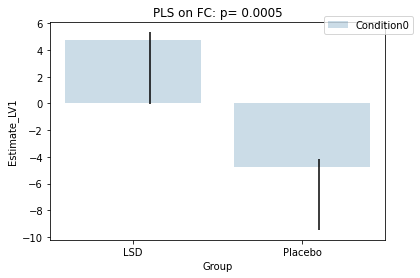

In [18]:
groups=['LSD', 'Placebo']

plot_contrast(mpls_fc, lv=0, group_labels=groups)

plt.title('PLS on FC: p= {p:1.4f}'.format(p= mpls_fc.permres.pvals[0]))


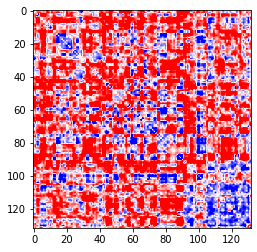

In [21]:
## reliability on connections
plt.imshow(mpls_fc.bootres.x_weights_normed[:,0].reshape(132,132), cmap='bwr', vmax= 2.1, vmin=-2.1)

PLS on EC 

In [22]:
data = np.concatenate([ec_lsd, ec_placebo], axis=0)

mpls_ec = meancentered_pls(data , mean_centering=1, n_perm=2000, n_boot=2000, groups= [45,45], n_cond=1) 
# run PLS with 2000 permutation and 2000 bootstrap


Running permutations:   0%|          | 0/2000 | 00:00<?/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:376: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  FutureWarning,


Text(0.5, 1.0, 'PLS on EC: p= 0.0005')

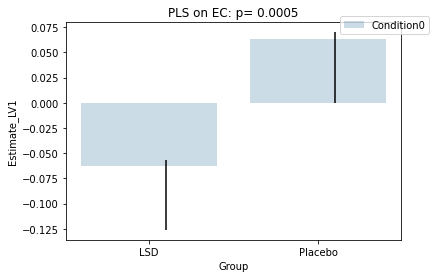

In [24]:
groups=['LSD', 'Placebo']

plot_contrast(mpls_ec, lv=0, group_labels=groups)

plt.title('PLS on EC: p= {p:1.4f}'.format(p= mpls_ec.permres.pvals[0]))

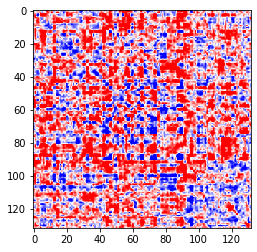

In [26]:
## reliability on connections
plt.imshow(-mpls_ec.bootres.x_weights_normed[:,0].reshape(132,132), cmap='bwr', vmax= 2.1, vmin=-2.1)

PLS on self Conne

In [27]:
data = np.concatenate([sc_lsd, sc_placebo], axis=0)

mpls_sc = meancentered_pls(data , mean_centering=1, n_perm=2000, n_boot=2000, groups= [45,45], n_cond=1) 
# run PLS with 2000 permutation and 2000 bootstrap

Running permutations:   0%|          | 0/2000 | 00:00<?/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:376: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  FutureWarning,


Text(0.5, 1.0, 'PLS on EC: p= 0.0005')

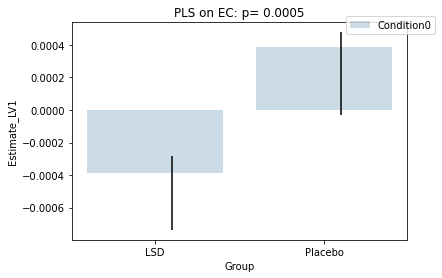

In [29]:
groups=['LSD', 'Placebo']

plot_contrast(mpls_sc, lv=0, group_labels=groups)

plt.title('PLS on EC: p= {p:1.4f}'.format(p= mpls_sc.permres.pvals[0]))

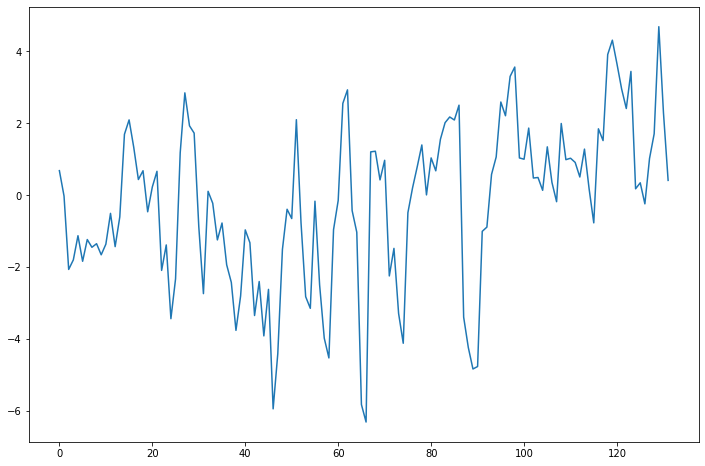

In [77]:
## reliability on self connection

fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(-mpls_sc.bootres.x_weights_normed[:,0])

In [41]:
## Brain plot on EC eigenvetor 'difference


eig = np.concatenate([np.zeros((1,)), -ec_weights])

In [42]:
 # design new colormap
 colors= [(0,201/255,239/255), (0,0,0), (1,181/255,0)]
 newcmp = LinearSegmentedColormap.from_list('mylist', colors, 500)
 

In [43]:
data = img.get_data()
new_data = eig[data]
"""new_data = data.copy()
new_data[data != 1] =0"""
new_img = nib.Nifti1Image(new_data, img.affine, img.header)

fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage5')
texture_r = surface.vol_to_surf(new_img, fsaverage['pial_right'], radius=3.0)
texture_l = surface.vol_to_surf(new_img, fsaverage['pial_left'], radius=3.0)
texture=np.concatenate([texture_l,texture_r])
vtx_r, tri_r = surface.load_surf_data(fsaverage['pial_right'])
vtx_l, tri_l = surface.load_surf_data(fsaverage['pial_left'])
vtx = np.vstack([vtx_l,vtx_r])
tri = np.vstack([tri_l,tri_r+tri_l.max()+1])

hemi = np.ones_like(texture)

hemi[:texture.shape[0]//2] = 0
hemi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """Entry point for launching an IPython kernel.


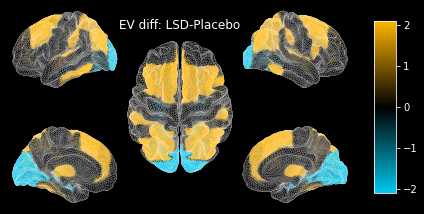

In [45]:
_cm = newcmp
kws = {'edgecolors': 'k', 'cmap': _cm, #$ 'Reds_r', #RdBu_r', # jet', 
       'vmax': 2.1,'vmin': -2.1, 'alpha': None, 'linewidth': 0.1, 'edgecolor':'white'}
plot_surface_mpl_mv(vtx=vtx, tri=tri, data=texture, reorient='fs', hemi=hemi, title= 'EV diff: LSD-Placebo',  shade_kwargs=kws)

Brain Plot on self t-test

In [62]:
weights = self_tt['tstat_sc'][:,0]
weights[np.abs(weights)< 2.1] = 0
eig = np.concatenate([np.zeros((1,)), weights])

In [63]:
data = img.get_data()
new_data = eig[data]
"""new_data = data.copy()
new_data[data != 1] =0"""
new_img = nib.Nifti1Image(new_data, img.affine, img.header)

fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage5')
texture_r = surface.vol_to_surf(new_img, fsaverage['pial_right'], radius=3.0)
texture_l = surface.vol_to_surf(new_img, fsaverage['pial_left'], radius=3.0)
texture=np.concatenate([texture_l,texture_r])
vtx_r, tri_r = surface.load_surf_data(fsaverage['pial_right'])
vtx_l, tri_l = surface.load_surf_data(fsaverage['pial_left'])
vtx = np.vstack([vtx_l,vtx_r])
tri = np.vstack([tri_l,tri_r+tri_l.max()+1])

hemi = np.ones_like(texture)

hemi[:texture.shape[0]//2] = 0
hemi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/nilearn/surface/surface.py:684: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([arr.data for arr in gifti_img.darrays]).T.squeeze()


array([0., 0., 0., ..., 1., 1., 1.])

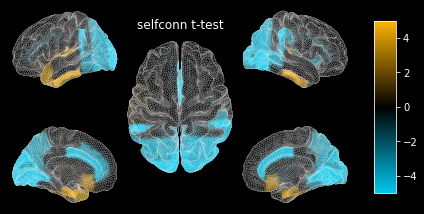

In [64]:
_cm = newcmp
kws = {'edgecolors': 'k', 'cmap': _cm, #$ 'Reds_r', #RdBu_r', # jet', 
         'vmax':5, 'vmin':-5,'alpha': None, 'linewidth': 0.1, 'edgecolor':'white'}
plot_surface_mpl_mv(vtx=vtx, tri=tri, data=texture, reorient='fs', hemi=hemi, title='selfconn t-test', shade_kwargs =kws)
#plt.savefig('selfconn_ttest.png', dvi =1000)

Brain Plot on Import Features

In [65]:

weights =self_if['datasc'][0]
eig = np.concatenate([np.zeros((1,)), weights])

In [66]:
data = img.get_data()
new_data = eig[data]
"""new_data = data.copy()
new_data[data != 1] =0"""
new_img = nib.Nifti1Image(new_data, img.affine, img.header)

fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage5')
texture_r = surface.vol_to_surf(new_img, fsaverage['pial_right'], radius=3.0)
texture_l = surface.vol_to_surf(new_img, fsaverage['pial_left'], radius=3.0)
texture=np.concatenate([texture_l,texture_r])
vtx_r, tri_r = surface.load_surf_data(fsaverage['pial_right'])
vtx_l, tri_l = surface.load_surf_data(fsaverage['pial_left'])
vtx = np.vstack([vtx_l,vtx_r])
tri = np.vstack([tri_l,tri_r+tri_l.max()+1])

hemi = np.ones_like(texture)

hemi[:texture.shape[0]//2] = 0
hemi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/nilearn/surface/surface.py:684: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([arr.data for arr in gifti_img.darrays]).T.squeeze()


array([0., 0., 0., ..., 1., 1., 1.])

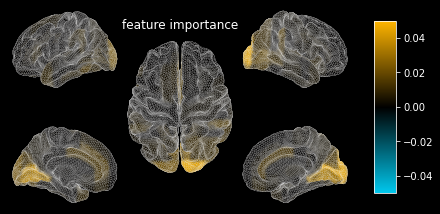

In [67]:
_cm = newcmp
kws = {'edgecolors': 'k', 'cmap': _cm, #$ 'Reds_r', #RdBu_r', # jet', 
         'vmax':0.05, 'vmin':-0.05, 'alpha': None, 'linewidth': 0.1, 'edgecolor':'white'}
plot_surface_mpl_mv(vtx=vtx, tri=tri, data=texture, reorient='fs', hemi=hemi, title='feature importance', shade_kwargs =kws)

PLS self connection differnce

In [74]:
weights = -mpls_sc.bootres.x_weights_normed[:,0]
weights[np.abs(weights)< 2.1] = 0
eig = np.concatenate([np.zeros((1,)), weights])

In [75]:
data = img.get_data()
new_data = eig[data]
"""new_data = data.copy()
new_data[data != 1] =0"""
new_img = nib.Nifti1Image(new_data, img.affine, img.header)

fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage5')
texture_r = surface.vol_to_surf(new_img, fsaverage['pial_right'], radius=3.0)
texture_l = surface.vol_to_surf(new_img, fsaverage['pial_left'], radius=3.0)
texture=np.concatenate([texture_l,texture_r])
vtx_r, tri_r = surface.load_surf_data(fsaverage['pial_right'])
vtx_l, tri_l = surface.load_surf_data(fsaverage['pial_left'])
vtx = np.vstack([vtx_l,vtx_r])
tri = np.vstack([tri_l,tri_r+tri_l.max()+1])

hemi = np.ones_like(texture)

hemi[:texture.shape[0]//2] = 0
hemi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/nilearn/surface/surface.py:684: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([arr.data for arr in gifti_img.darrays]).T.squeeze()


array([0., 0., 0., ..., 1., 1., 1.])

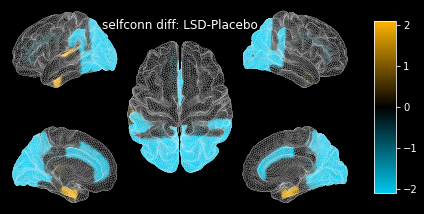

In [76]:
_cm = newcmp
kws = {'edgecolors': 'k', 'cmap': _cm, #$ 'Reds_r', #RdBu_r', # jet', 
        'vmax': 2.1,'vmin': -2.1, 'alpha': None, 'linewidth': 0.1, 'edgecolor':'white'}
plot_surface_mpl_mv(vtx=vtx, tri=tri, data=texture, reorient='fs', hemi=hemi, title='selfconn diff: LSD-Placebo', shade_kwargs =kws)